In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
 
import datetime
import warnings
warnings.filterwarnings("ignore")

# Загрузка размеченных новостей: 
**нужна метка класса и вероятность принадлежности к классу**

In [8]:
def relative_count(df, column, type): # type can be ['to_year', 'to_month']
    if type == 'to_year':
        for i in range(12, len(df)):
            df.at[i, f'relative_{column}'] = df.at[i, column] / (df.at[i - 12, column] + 1e-4)
    elif type == 'to_month':
        for i in range(1, len(df)):
            df.at[i, f'relative_{column}'] = df.at[i, column] / (df.at[i - 1, column] + 1e-4)
    return df[f'relative_{column}']

In [29]:
def graphs(target_csv, index_timerow, legend_name, save=False):
    
    target = pd.read_csv(target_csv)
    target.index = target.date
    target.drop(columns= 'date', inplace=True)
    target.index = pd.date_range(start = '2014-01-01', end = '2024-08-31', freq="ME")
    
    # target = target.resample('QE').mean()
    
    concated = pd.concat([target, index_timerow], axis=1)['2015-01-31':'2024-12-31']
    
    target_name = target.columns[0]
    index_name = index_timerow.columns[0]
    
    fig, ax  = plt.subplots(figsize=(18,4))
    
    ax.plot(concated[target_name],color='blue', label = target_name)  
    ax.grid()
    
    ax2 = ax.twinx()
    ax2.plot(concated[index_name] ,color='red', label = legend_name)
    
    nticks = 7
    ax.yaxis.set_major_locator(ticker.LinearLocator(nticks))
    ax2.yaxis.set_major_locator(ticker.LinearLocator(nticks))
    
    ax.legend([target_name], loc = 'upper right') 
    ax2.legend([legend_name], loc = 'lower right')
    if save==True: 
        plt.savefig(f'{legend_name} {target_name}.png')
    plt.show()

# Пайплайн для индекса по категориям:
- создание сводной таблицы, где столбцы - категории новостей
- группировка *средним* по каждому месяцу
- заполнение пропущенных значений NaN нулями
- (один из вариантов, чаще плохой) пересчет значений каждого месяца по отношению к предыдущему       t / (t-1) + .1e-4    
- сглаживание данных скользящим окном за 3 месяца

вывод: {'корреляция полученного индекса с фактическим значением: ___ ',
            'временной ряд полученного индекса: ___ '}


In [32]:
def main_categories(target_csv, news_csv, type, score=True):
  
    target = pd.read_csv(target_csv)
    target.index = pd.to_datetime(target.date)
    target.drop(columns= 'date', inplace=True)
    target_name = target.columns[0]
    
    # для ВВП нужно агрегировать месячные данные в квартальные
    # target = target.resample('QE').mean()
    
    data = pd.read_csv(news_csv)
    data['sentiment_class'] = data['sentiment_class'].replace({'neutral': 0, 'positive': 1, 'negative': -1})

    # make all date format "%Y-%m-%dT%H:%M:%S"
    data['date'] = [date[:19] for date in data.date]
    
    if score == True:
        data['sentiment_score'] = data['sentiment_class'] * data['sentiment_prob']
        data_pivot = data.pivot_table(index = 'date', columns = 'category', values = 'sentiment_score')
    else:
        data_pivot = data.pivot_table(index = 'date', columns = 'category', values = 'sentiment_class')
    
    data_pivot.columns.name = None

    data_pivot.index = pd.to_datetime(data_pivot.index)
    data_pivot = data_pivot['2014-01-01':]
    
    data_pivot = data_pivot.resample('ME').mean()
    
    data_group = data_pivot.fillna(0)  
    
    data_group.reset_index(inplace=True)

    [relative_count(data_group, name, type) for name in data_group.columns[1:]]
    
    data_relative = data_group.iloc[:, 1:]
    data_relative.index = data_group['date']

    data_relative_mean = data_relative.rolling(window = 3).mean()
    
    # для ВВП нужно агрегировать месячные данные в квартальные
    # data_relative_mean = data_relative_mean.resample('QE').mean()
    
    concated = pd.concat([target, data_relative_mean], axis=1)['2015-01-31':'2024-12-31']
    
    sorted = concated.corr()[[target_name]].sort_values([target_name], ascending=False)
    sorted = sorted.dropna()
    
    if abs(sorted.values[1]) > abs(sorted.values[-1]):
        max_corr = sorted.iloc[[1]]
    else: 
        max_corr = sorted.iloc[[-1]]
 
    return {'max correlation': max_corr, 'timerow': concated[max_corr.index]}

# Результат

In [39]:
# размеченные новости за определенный период.csv
news_for_idx = 'texts_for_idx.csv'

# значения макроэкономического показателя за тот же период
macro_target = 'target_ipp.csv'

result = main_categories(macro_target, news_for_idx, type = 'to_year', score = True)
result['max correlation']

,ИПП в % к соответствующему месяцу предыдущего года
Экономика и бизнес,0.627307


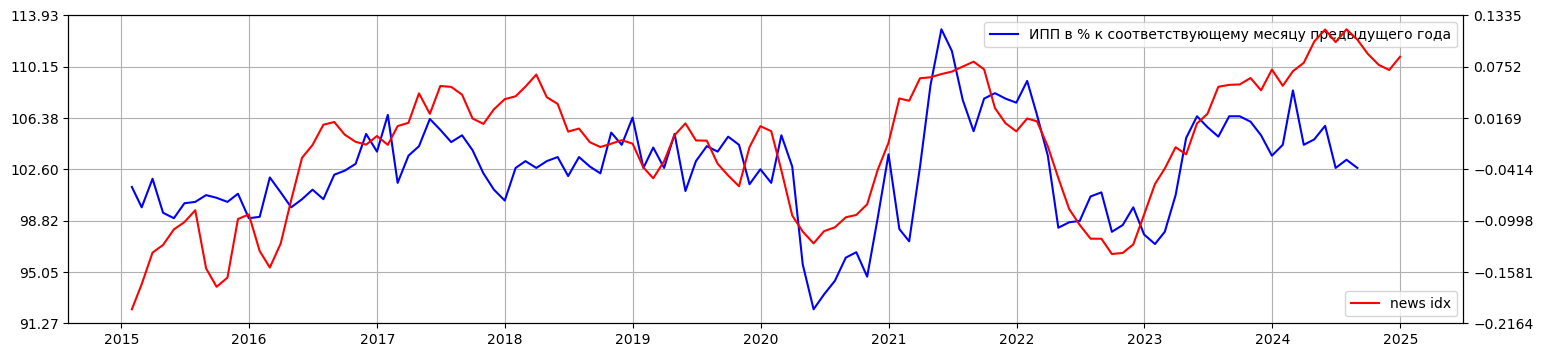

In [41]:
graphs(macro_target, result['timerow'], 'news idx')